# **Project ATP Matches**

> Name: **Samuel Lozano Gómez** 

### Table of contents <a id="0"></a>

***

- [Part 1](#part1)
    - 1.1 [Dataset](#1.1)
        - 1.1.1 [Description](#description)
        - 1.1.2 [Importing libraries](#importing)
        - 1.1.3 [Preprocess of the data](#preprocess)
        - 1.1.4 [Network creation](#creation)
    - 1.2 [Network characterization](#1.2)
        - 1.2.1 [Giant component extraction](#121)
        - 1.2.2 [Measures](#122)
        - 1.2.3 [Discussion](#123)
    - 1.3 [Centrality measures. Identification of relevant nodes](#1.3)
        - 1.3.1 [Degree](#131)
        - 1.3.2 [Closeness](#132)
        - 1.3.3 [Betweenness](#133)
        - 1.3.4 [Eigenvector Centrality](#134)
        - 1.3.5 [Betweenness Centrality without weights](#135)
        - 1.3.6 [Discussion](#136)
    - 1.4 [Comparison with a random network](#1.4)
        - 1.4.1 [Degree Distribution](#141)
        - 1.4.2 [Clustering Coefficient](#142)
        - 1.4.3 [Small-world Phenomena](#143)
    
***

- [Part 2](#part2)
    - 2.1 [Community analysis](#2.1)
        - 2.1.1 [Eigenvalues](#211)
        - 2.1.2 [Girvan Newman Method](#212)
        - 2.1.3 [Louvain Method](#213)
        - 2.1.4 [Discussion](#214)
    - 2.2 [Extension of the Analysis](#2.2)
        - 2.2.1 [Percolation](#221)
        - 2.2.2 [Robustness](#222)
        - 2.2.3 [Deliberate Attack](#223)
        - 2.2.4 [Cascades](#224)
    - 2.3 [Conclusions](#2.3)
    - 2.4 [Future Proposals](#2.4)
    - 2.5 [References](#2.5)
***

# [Part 1](#0) <a id="part1"></a>

## 1.1 [Dataset](#0) <a id="1.1"></a>

### 1.1.1 [Description](#0) <a id="description"></a>

This network is about the games played by men in the Professional Tennis Association in 2023. Every year, the tennis season includes lots of tournaments of different importance. There are 4 Grand Slams, which are the most important, then Master’s 1000, 500, 250, and other tournaments that give ATP points like national selections tournaments. So, the network is defined as players, de nodes, and games between them, the edges. It is an undirected graph in order that if a sportsman plays versus another, then an edge from one to the other is set. Also, there is a weighted graph that takes the number of games that both sportsmen have played versus each other.

The dataset that corresponds to this network is in [1]. Much information is present in it, so many edge attributes like the surface, the date, the points won, the result of the match, etc. Also, information for players, such as name, nationality and playing hand. We do not know the exact number of nodes yet because players there are 2000, but not everyone can play an ATP match; maybe we will find 300 or 400; we will see that number when we do the cleaning, and 2986 edges, which also will be reduced in the cleaning. As we will see, there will be players with no games played due to some issue or just because their ranking is too low, so they can only play a few matches. Others are probably the best players because they have more games played. In tennis, as tournaments follow an eliminatory format, the more wins you also have, the more games you play; games and wins are highly correlated.

Having said this, we will do a complete network analysis of this, starting with a cleaning process. We could build our network differently as we have many attributes and different networks could be performed, but this is the essential and principal focus of doing it, as we are interested in extracting value from metrics.

[1] __[Dataset](https://github.com/JeffSackmann/tennis_atp/blob/master/atp_matches_2023.csv)__

### 1.1.2 [Importing libraries](#0) <a id="importing"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from prettytable import PrettyTable
from scipy.stats import pearsonr
import networkx.algorithms.community as nx_comm
from tqdm import tqdm
import math
import io
import json
import gzip
import csv
import re
import powerlaw

### 1.1.3 [Preprocess of the data](#0) <a id="preprocess"></a>

**Rankings Dataset**

We take the rankings of the 02-01-2023, the first week of the year, so we won't consider the changes during the season

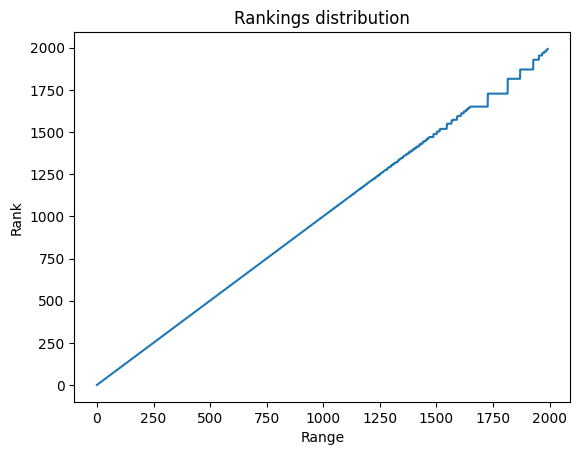

In [4]:
rankings = pd.read_csv("rankings.csv")

rankings["ranking_date"] = pd.to_datetime(rankings["ranking_date"], format="%Y%m%d")
rankings = rankings[rankings["ranking_date"]>pd.to_datetime("20221231", format="%Y%m%d")]
rankings = rankings[rankings["ranking_date"]==rankings["ranking_date"].unique()[0]]
rankings = rankings.sort_values(by="rank")

plt.title("Rankings distribution")
plt.plot(range(len(rankings["rank"])), rankings["rank"])
plt.ylabel("Rank")
plt.xlabel("Range")

plt.show()

#Some players have the same rank but it won't be a problem

**Players Dataset**

We select the players that has at least one game played in 2023 and filter the ranking list and the players dataset. Then we merge to have one single dataframe with the ranking and the name of players.

In [5]:
aux = pd.read_csv("matches.csv")
winners_ids = list(aux["winner_id"])
lossers_ids = list(aux["loser_id"])

for ID in lossers_ids:
    winners_ids.append(ID)
players_id = set(winners_ids)

aux = pd.read_csv("players.csv")
aux = aux[aux["player_id"].isin(players_id)]

players = pd.merge(rankings, aux, left_on="player", right_on = "player_id")
players = players.drop(columns = ["player_id"])
players

,ranking_date,rank,player,points,name_first,name_last,hand,dob,ioc,height,wikidata_id
0,2023-01-02,1,207989,6820,Carlos,Alcaraz,R,20030505.0,ESP,185.0,Q85518537
1,2023-01-02,2,104745,6020,Rafael,Nadal,L,19860603.0,ESP,185.0,Q10132
2,2023-01-02,3,134770,5820,Casper,Ruud,R,19981222.0,NOR,183.0,Q18810082
3,2023-01-02,4,126774,5550,Stefanos,Tsitsipas,R,19980812.0,GRE,193.0,Q24450982
4,2023-01-02,5,104925,4820,Novak,Djokovic,R,19870522.0,SRB,188.0,Q5812
...,...,...,...,...,...,...,...,...,...,...,...
391,2023-01-02,1644,208206,2,Walid,Ahouda,U,20031014.0,MAR,NaN,NaN
392,2023-01-02,1651,144807,1,Kenneth,Raisma,L,19980403.0,EST,NaN,Q23039413
393,2023-01-02,1728,209280,1,Devin,Badenhorst,R,20040520.0,RSA,NaN,NaN
394,2023-01-02,1871,207587,1,Martins,Rocens,U,20000409.0,LAT,NaN,NaN


**Matches Dataset**

Here we don't need extra processes

In [6]:
matches = pd.read_csv("matches.csv")
matches

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2023-9900,United Cup,Hard,18,A,20230102,300,126203,3.0,NaN,...,62.0,47.0,15.0,12.0,9.0,9.0,9.0,3355.0,16.0,2375.0
1,2023-9900,United Cup,Hard,18,A,20230102,299,126207,NaN,NaN,...,12.0,8.0,3.0,4.0,1.0,3.0,19.0,2000.0,23.0,1865.0
2,2023-9900,United Cup,Hard,18,A,20230102,296,126203,3.0,NaN,...,62.0,51.0,7.0,12.0,2.0,2.0,9.0,3355.0,10.0,2905.0
3,2023-9900,United Cup,Hard,18,A,20230102,295,126207,NaN,NaN,...,41.0,26.0,12.0,9.0,6.0,9.0,19.0,2000.0,245.0,220.0
4,2023-9900,United Cup,Hard,18,A,20230102,292,126774,1.0,NaN,...,58.0,48.0,18.0,16.0,1.0,2.0,4.0,5550.0,16.0,2375.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981,2023-M-DC-2023-WG2-PO-RSA-LUX-01,Davis Cup WG2 PO: RSA vs LUX,NaN,4,D,20230204,5,202335,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1717.0,1.0
2982,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,NaN,4,D,20230203,1,117365,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,990.0,11.0,279.0,190.0
2983,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,NaN,4,D,20230203,2,121411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,364.0,131.0,894.0,15.0
2984,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,NaN,4,D,20230203,4,144949,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,894.0,15.0,285.0,184.0


### 1.1.4 [Network Creation](#0) <a id="creation"></a>

**Nodes and Edges**

In [7]:
dic_matches = {}

for i,row in matches.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    if (winner, loser) in dic_matches:
        dic_matches[(winner, loser)] += 1
    elif (loser, winner) in dic_matches:
        dic_matches[(loser, winner)] += 1
    else:
        dic_matches[(winner, loser)] = 1

In [8]:
print(f"This network has {len(players_id)} nodes (players) and {len(dic_matches)} edges (Two players have played between them at least one time)")        

This network has 440 nodes (players) and 2577 edges (Two players have played between them at least one time)


**Edges' file**

In [9]:
output_filename = "und_players_matches_edges.csv"

with io.open(output_filename, "w") as output_file:
    writer = csv.writer(output_file, delimiter='\t', quotechar='"', lineterminator='\n')
    writer.writerow(["Source", "Target", "Weight"])
    for (target, source), weight in dic_matches.items():
        writer.writerow([target, source, weight])

**Nodes' file**

In [10]:
output_filename = "und_players_matches_nodes.csv"

with io.open(output_filename, "w") as output_file:
    writer = csv.writer(output_file, delimiter='\t', quotechar='"', lineterminator='\n')
    writer.writerow(["Name", "Country", "Rank", "Points", "Hand", "Height"])
    for i, row in players.iterrows():
        Name = " ".join([row["name_first"], row["name_last"]])
        Country = row["ioc"]
        Rank = row["rank"]
        Points = row["points"]
        Hand = row["hand"]
        Height = row["height"]
        writer.writerow([Name, Country, Rank, Points, Hand, Height])

**Comments**

Until now we have the dictionaries with the nodes and the edges with their weights, so its time to decide wether work on cytoescape or in jupyter with the networkx library.

We will combine both, as both give us interesting visualizations

Here we show the network in Cytoescape

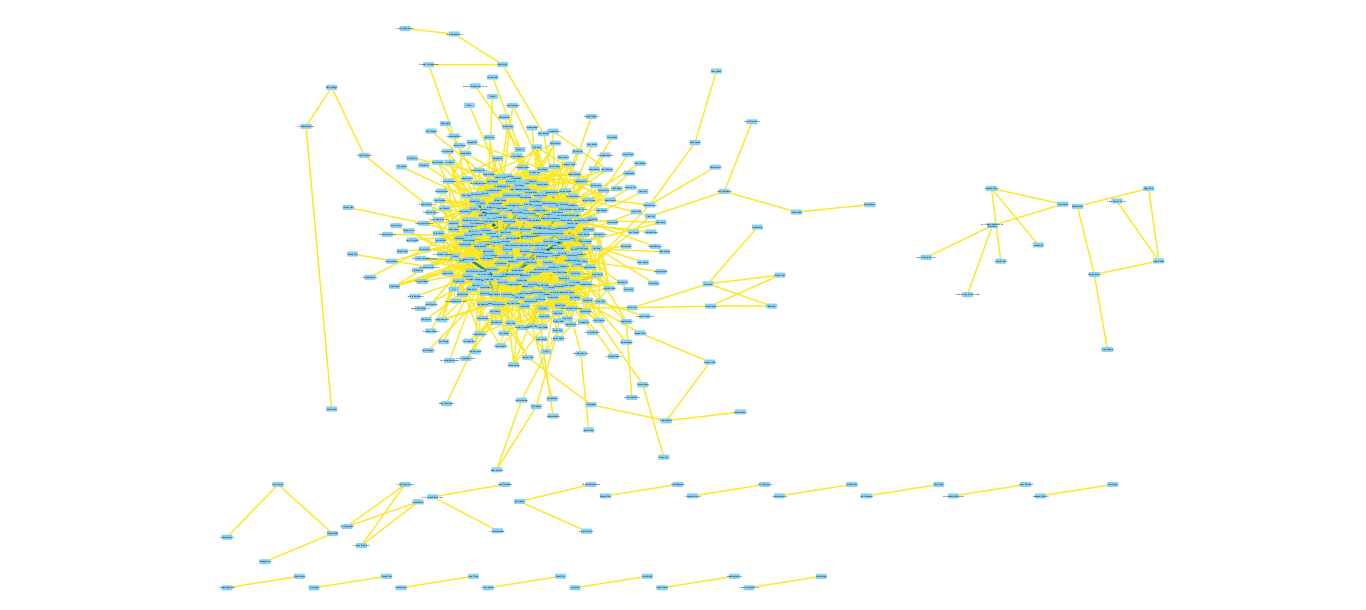

## 1.2 [Network characterization](#0) <a id="1.2"></a>

If we look at the previous picture, we can see several components in the network. Let us extract it, as we will work with it throughout the analysis, comparing it first with the entire network. This time, we work with Networkx.

### 1.2.1 [Giant component extraction](#0) <a id="121"></a>

**Nodes of Connected Components of the network**

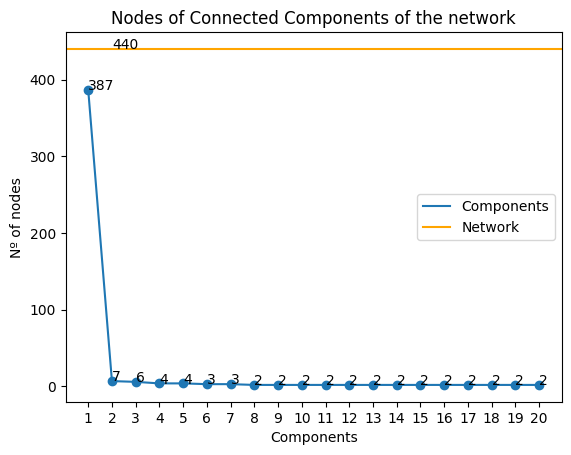

In [11]:
# We charge the network from the csv files created before
df = pd.read_csv("und_players_matches_edges.csv", sep="\t")
G = nx.Graph()
G.add_weighted_edges_from([(i,k,v) for (i,k),v in dic_matches.items()])

# We extract the Components and take the bigger one.
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

sizes = [len(cc) for cc in Gcc]
ranges = range(len(sizes))

#Let's plot the Connected Components
plt.title("Nodes of Connected Components of the network")
plt.plot(sizes, label="Components")
plt.scatter(ranges, sizes)

for i, label in enumerate(sizes):
    plt.annotate(str(sizes[i]), (ranges[i],sizes[i]))

plt.axhline(len(G.nodes), color="orange", label="Network")
plt.annotate(len(G.nodes), (1,len(G.nodes)))

plt.xticks(range(20), range(1,21))
plt.xlabel("Components")
plt.ylabel("Nº of nodes")
plt.legend(loc="best")

plt.show()   

**Edges of Connected Components of the network**

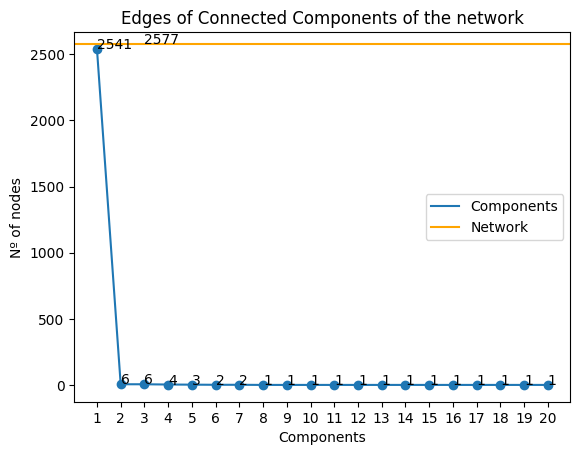

In [12]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

sizes = []
for i,cc in enumerate(Gcc):
    sizes.append(len(nx.subgraph(G, Gcc[i]).edges))
ranges = range(len(sizes))

#Let's plot the Connected Components
plt.title("Edges of Connected Components of the network")
plt.plot(sizes, label="Components")
plt.scatter(ranges, sizes)
for i, label in enumerate(sizes):
    plt.annotate(str(sizes[i]), (ranges[i],sizes[i]))

plt.axhline(len(G.edges), color="orange", label="Network")
plt.annotate(len(G.edges), (2,len(G.edges)))

plt.xticks(range(20), range(1,21))
plt.xlabel("Components")
plt.ylabel("Nº of nodes")
plt.legend(loc="best")
plt.show()   

**This is the Giant Component (G0)**

In [13]:
G0 = G.subgraph(Gcc[0])

**Comments**

As we can see in the graphs, we have 440 nodes and 2577 edges in the complete network, and in the Giant Component, we have 387 nodes and 2541 edges. Only a little information is lost.

We have the exciting information. The giant component is the subgraph of the network where the best players take part as they are the ones who play the most as they regularly play in the ATP matches. The other components are players with a low quantity of games, and those games are also against players with low games because these players, because of their low ranking, cannot play with other good players. Arriving to play an ATP match, they were joined by another low-ranking player who played a few games. The case where an unknown player plays against a top player is seen in the giant components on the leaves.

### 1.2.2 [Measures](#0) <a id="122"></a>

We will calculate some attributes of our network (Giant Component)

**Average Degree and Degree Distribution**

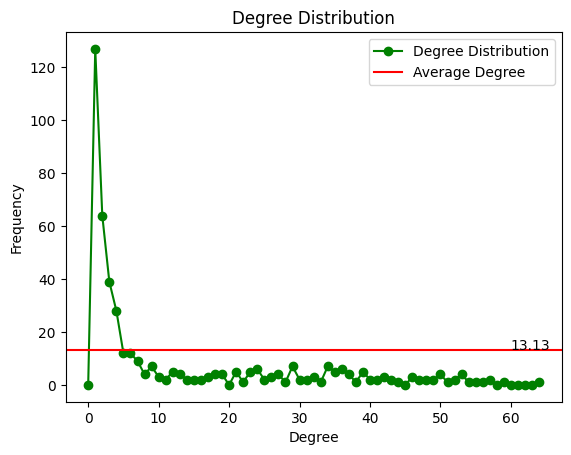

In [14]:
# Average Degree
mean = np.mean(list(dict(G0.degree).values()))

# Degree Dristribution
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.title("Degree Distribution")
plt.plot(degrees, degree_freq,'go-', label="Degree Distribution") 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.axhline(mean, color="red", label="Average Degree")
plt.annotate("{:.2f}".format(mean), (60,mean))
plt.legend(loc="best")
plt.show()

**Diameter, ASPL and Density**

In [15]:
#Diameter
print("The diameter of the network is",nx.diameter(G0))

# Average shortest path length
print("The ASPL is",nx.average_shortest_path_length(G0))

# Density
print("The Density is",nx.density(G0))

The diameter of the network is 11
The ASPL is 3.1955255653291563
The Density is 0.03402016307185605


**Heterogeneity**
(from Cytoescape)


**Clustering Index**

In [16]:
print(nx.average_clustering(G0))

0.13408480480098714


**Summary table of measures**
<br>
<br>
| Measure | Value | 
| :---    |  ---: |  
| Avg Degree | 13.130 | 
| Diameter    | 11 | 
| ASPL | 3.195 |
| Density | 0.034 |
| Heterogeneity | 1.220 |
| Clust. Index | 0.134 |

**Code to do the "Relation Rank-Matches" graphic explained in the next cell**

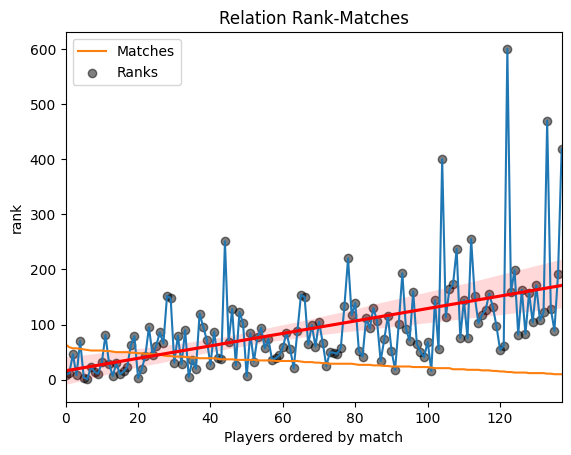

In [18]:
def clave_ordenacion(tupla):
    return [-tupla[1], tupla[0]]

players["name"] = players["name_first"]+" "+players["name_last"] 
degrees = [[x,y] for x,y in dict(G0.degree).items() if y>=10]
degrees = sorted(degrees, key=clave_ordenacion)

for i,(k,v) in enumerate(degrees):
    try:
        rank = players["rank"][players["name"]==k].values[0]
    except:
        rank = 400
    degrees[i].append(rank)

games = [x[1] for x in degrees]
ranks = [x[2] for x in degrees]

df_degrees = pd.DataFrame(degrees)
df_degrees.columns = ["name", "matches", "rank"]
df_degrees["index"] = range(len(ranks))

"""
The next part of the code allows to plot the graphic
"""

"""
plt.title("Relation Rank-Matches")
plt.plot(range(len(ranks)), ranks)
plt.plot(range(len(ranks)), games, label="Matches")
sns.regplot(x = df_degrees["index"], y = df_degrees["rank"],
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"},
            ci = 99, label="Ranks") 
plt.xlabel("Players ordered by match")
plt.legend(loc="best")
plt.show()
"""

### 1.2.3 [Discussion](#0) <a id="123"></a>

Once the most relevant metrics have been calculated we can say that it is a fairly homogeneous network, this is shown by the Hetrogeneity value calculated in Cytoescape, being this value very low, almost equal to 1. This means that there is little diversity in the function performed by the nodes within the network, this is explained in [2]. We see that there is a large number of leaves, almost a third, that is they have only played 1 ATP match in the whole year. We see that the frequency between playing a number of matches between 10 and 70 remains more or less constant, this makes sense knowing that here are concentrated the regular players of the circuit, who by ranking can frequently access the tournaments, and as we said at the beginning, the number of matches is highly correlated with the quality of the player, in this range of matches are mostly the best players of the circuit almost sorted by ranking. We can make a graph out of it:

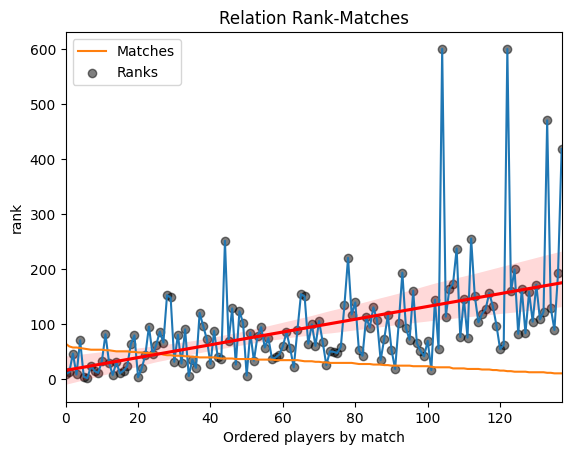

As we can see the red slope is increasing, this means that as the number of matches of a player decreases (orange line) the average ranking increases (expressed by the red line that adjusts to the black dots). Although this is only to demonstrate the knowledge that is extracted from the grade distribution. 

Also, regarding the Degree Distribution, we could say that it is a scale-free network that follows the same power law structure, concentrating the most significant part of nodes in the small grade values. Then, the line decreases exponentially until the few highest values are reached.

In addition, on the remaining metrics it is a network that differs greatly from a complete graph, with a density of 0.034, to be complete each player should play 386 games a year, knowing that there are 365 days, play more than one game a day, which is impossible because there are not so many games, nor a player can play so many. Regarding the diameter is quite low, a value of 11, which is the largest distance between two nodes, as well as the Average Shortest Path Length of 3.19, on average only 3 connections are needed to reach another player, this is an indication of the Small World effect that we will analyse later.

Finally, the Clustering index is also low, as we have a low density, it is also common to have a low average clustering coefficient.

[2] __[Heterogeneity](https://www.researchgate.net/figure/Networks-with-different-values-of-H-the-network-heterogeneity-where-K-is-the-average_fig14_262607676)__


## 1.3. [Centrality measures. Identification of relevant nodes](#0) <a id="1.3"></a>

### 1.3.1 [Degree](#0) <a id="131"></a>

Regarding the degree, as we have seen above, the most relevant nodes would be those with the highest degree, we can show the top 10 with the most games played. In addition, we show a picture of the Cytoescape network, observing the location of these nodes with higher degree.

In [19]:
myTable = PrettyTable(["Name", "Degree", "Rank"])
for i,j,k in degrees[:10]:
    myTable.add_row([i,j,k])
print(myTable)

+--------------------+--------+------+
|        Name        | Degree | Rank |
+--------------------+--------+------+
|    Taylor Fritz    |   64   |  9   |
|  Alexander Zverev  |   59   |  12  |
|  Adrian Mannarino  |   57   |  46  |
|   Andrey Rublev    |   57   |  8   |
|    Laslo Djere     |   56   |  70  |
| Stefanos Tsitsipas |   55   |  4   |
|   Carlos Alcaraz   |   54   |  1   |
|   Alex De Minaur   |   53   |  24  |
|   Cameron Norrie   |   53   |  14  |
|    Holger Rune     |   53   |  11  |
+--------------------+--------+------+


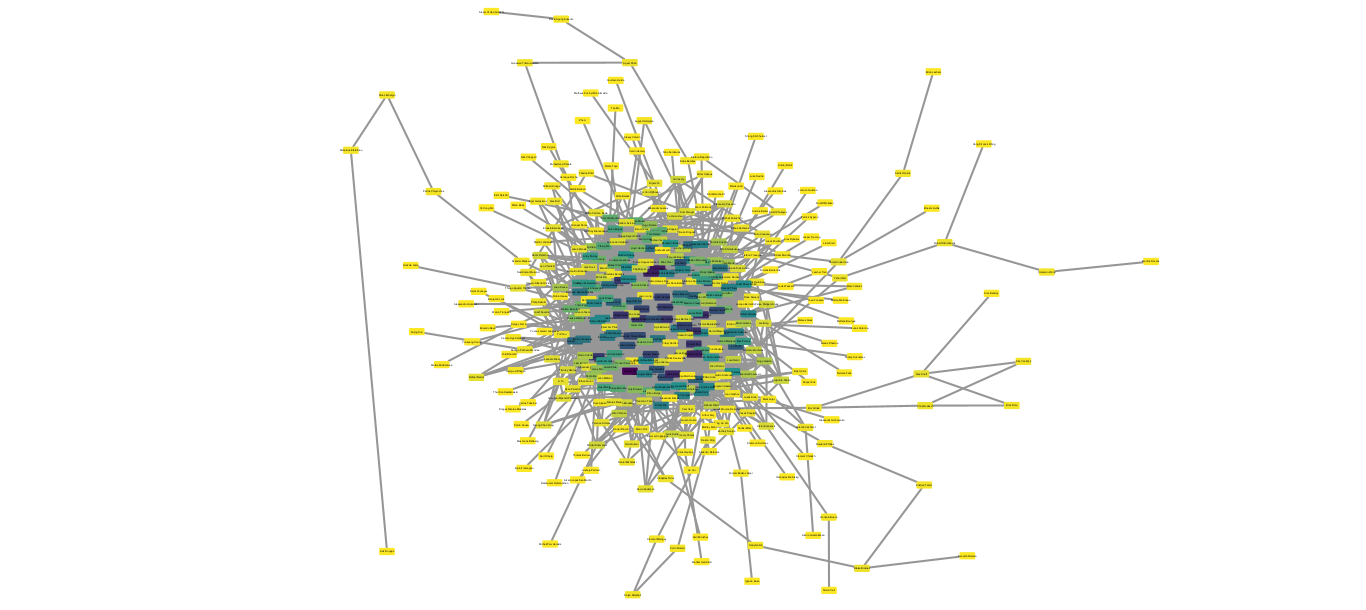

### 1.3.2 [Closeness](#0) <a id="132"></a>

Regarding closeness centrality we want to see which nodes are placed in central positions, closer to the middle of the network diameter. We can see that most of the players repeat, although they all have very similar values between them. In the picture we can see that there is not much difference between them.

In [20]:
close = nx.closeness_centrality(G0)
close = [[x,y] for x,y in dict(close).items()]
close = sorted(close, key=clave_ordenacion)

for i,(k,v) in enumerate(close):
    try:
        rank = players["rank"][players["name"]==k].values[0]
    except:
        rank = 400
    close[i].append(rank)

myTable = PrettyTable(["Name", "Closeness", "Rank"])
for i,j,k in close[:10]:
    myTable.add_row([i,"{:.4f}".format(j), k])
print(myTable)

+-------------------------+-----------+------+
|           Name          | Closeness | Rank |
+-------------------------+-----------+------+
|       Taylor Fritz      |   0.4536  |  9   |
|      Andrey Rublev      |   0.4457  |  8   |
|        Tommy Paul       |   0.4386  |  32  |
|     Alexander Zverev    |   0.4376  |  12  |
| Tomas Martin Etcheverry |   0.4371  |  79  |
|       Holger Rune       |   0.4347  |  11  |
|      Jannik Sinner      |   0.4342  |  15  |
|      Alex De Minaur     |   0.4327  |  24  |
|     Daniil Medvedev     |   0.4327  |  7   |
|       Jiri Lehecka      |   0.4323  |  81  |
+-------------------------+-----------+------+


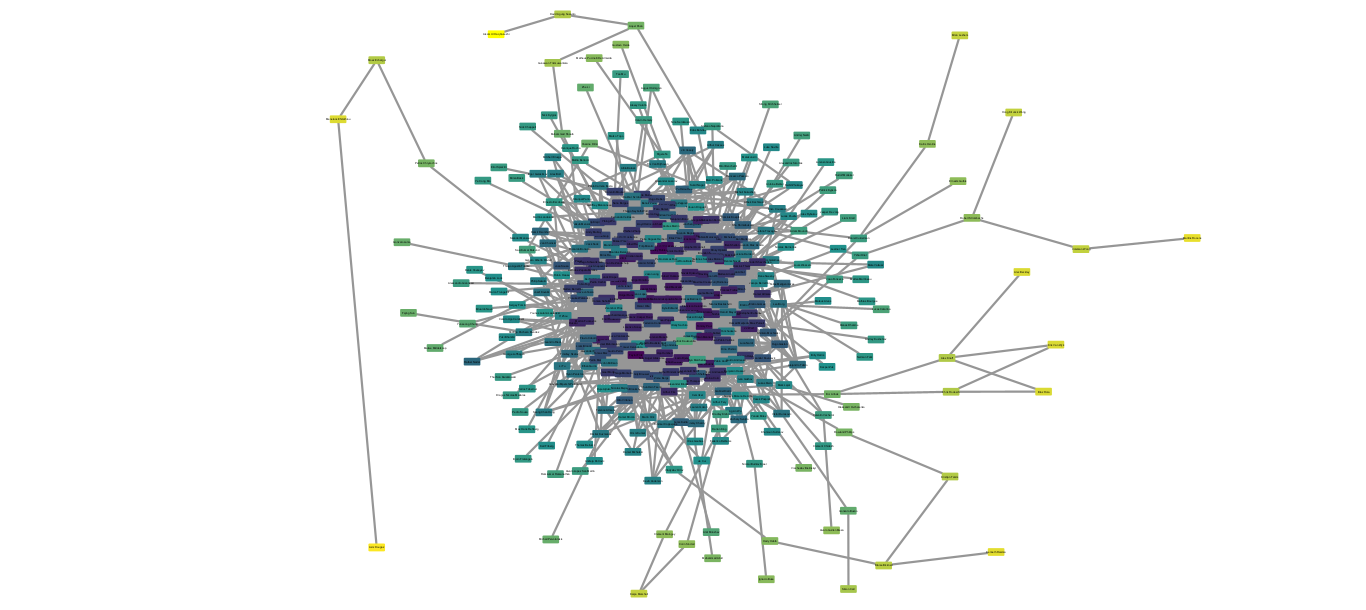

### 1.3.3 [Betweenness](#0) <a id="133"></a>

Regarding Betweenness, we focus on the shortest paths and which nodes are present in most of them, giving rise to bridge nodes that link different connected components within the network. At first glance we see that we are not going to find many positions, as the central core contains many variants by which to reach a destination. We also see the values of the top 10 and the network coloured by this measure of centrality. Here is surprising the presence of Michael Mmoh and Cem Ilkel who were not present before, as they are two players with a low ranking (high number). This is probably because they act as a bridge between the net and a group of lesser-known players that no one among the regular players on the circuit has played.

In [23]:
bet = nx.betweenness_centrality(G0, weight="weight")
bet = [[x,y] for x,y in dict(bet).items()]
bet = sorted(bet, key=clave_ordenacion)

for i,(k,v) in enumerate(bet):
    try:
        rank = players["rank"][players["name"]==k].values[0]
    except:
        rank = 400
    bet[i].append(rank)
     
myTable = PrettyTable(["Name", "Betweenness", "Rank"])
for i,j,k in bet[:10]:
    myTable.add_row([i,"{:.4f}".format(j), k])
print(myTable)

+-------------------------+-------------+------+
|           Name          | Betweenness | Rank |
+-------------------------+-------------+------+
| Tomas Martin Etcheverry |    0.0516   |  79  |
|      Alex De Minaur     |    0.0481   |  24  |
|    Miomir Kecmanovic    |    0.0406   |  29  |
|       Taylor Fritz      |    0.0366   |  9   |
|      Cameron Norrie     |    0.0351   |  14  |
|       Laslo Djere       |    0.0341   |  70  |
|        Tommy Paul       |    0.0336   |  32  |
|       Michael Mmoh      |    0.0330   | 113  |
|        Cem Ilkel        |    0.0310   | 378  |
|    Daniel Elahi Galan   |    0.0299   |  67  |
+-------------------------+-------------+------+


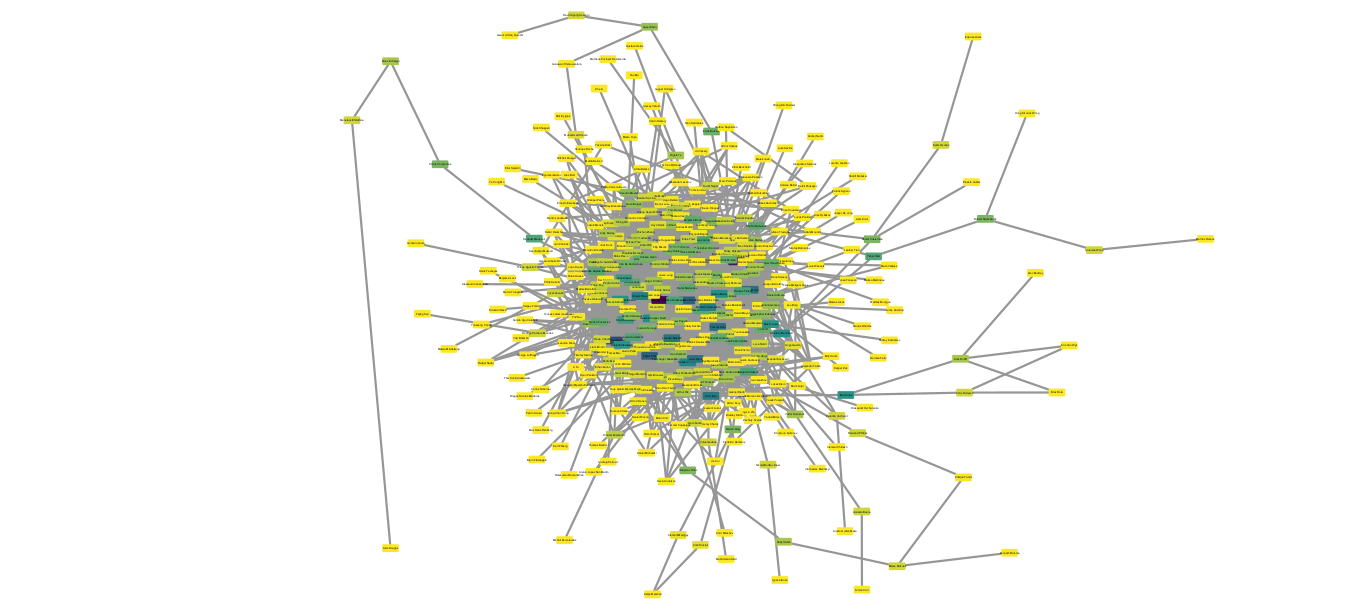

### 1.3.4 [Eigenvector Centrality](#0) <a id="134"></a>

Regarding Eigenvector Centrality, as with Page Rank, the top players feed back to each other, so it is not surprising that they are in the top 10 with the highest values. The best players often reach the final rounds, playing against good players, so they are mutually targeted with connections of importance, which this measure of centrality rewards.

In [25]:
eigen = nx.eigenvector_centrality(G0, weight="weight")
eigen = [[x,y] for x,y in dict(eigen).items()]
eigen = sorted(eigen, key=clave_ordenacion)

for i,(k,v) in enumerate(eigen):
    try:
        rank = players["rank"][players["name"]==k].values[0]
    except:
        rank = 600
    eigen[i].append(rank)
    
myTable = PrettyTable(["Name", "Eigen. Vec. Cent.", "Rank"])
for i,j,k in eigen[:10]:
    myTable.add_row([i,"{:.4f}".format(j),k])
print(myTable)

+--------------------+-------------------+------+
|        Name        | Eigen. Vec. Cent. | Rank |
+--------------------+-------------------+------+
|  Daniil Medvedev   |       0.2261      |  7   |
|   Jannik Sinner    |       0.2167      |  15  |
|   Andrey Rublev    |       0.1973      |  8   |
|  Alexander Zverev  |       0.1963      |  12  |
|   Carlos Alcaraz   |       0.1910      |  1   |
|   Novak Djokovic   |       0.1747      |  5   |
|  Grigor Dimitrov   |       0.1724      |  28  |
| Stefanos Tsitsipas |       0.1627      |  4   |
|   Alex De Minaur   |       0.1585      |  24  |
|    Holger Rune     |       0.1513      |  11  |
+--------------------+-------------------+------+


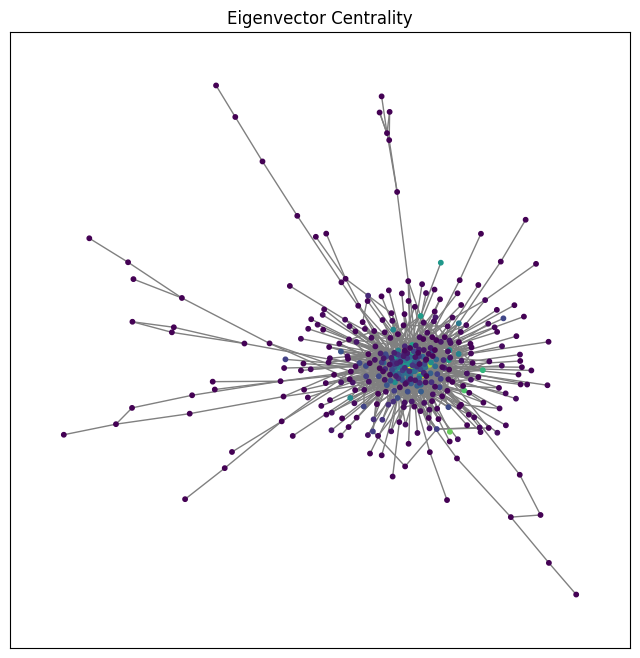

In [26]:
plt.figure(figsize=(8,8))
plt.title("Eigenvector Centrality")
nx.draw_networkx(G0, node_color=[x[1] for x in eigen], node_size = 10, with_labels=False, edge_color="grey") 

### 1.3.5 [Betweenness Centrality without weights](#0) <a id="135"></a>

We are using a weighted network, but we can also compute the metrics with the non-weighted variant. The results are going to be very similar, due to almost all weights are equal to 1, but let's see.

In [28]:
bet = nx.betweenness_centrality(G0)
bet = [[x,y] for x,y in dict(bet).items()]
bet = sorted(bet, key=clave_ordenacion)

for i,(k,v) in enumerate(bet):
    try:
        rank = players["rank"][players["name"]==k].values[0]
    except:
        rank = 600
    bet[i].append(rank)
    
myTable = PrettyTable(["Name", "Betweenness No Weights", "Rank"])
for i,j,k in bet[:10]:
    myTable.add_row([i,"{:.4f}".format(j),k])
print(myTable)

+-------------------------+------------------------+------+
|           Name          | Betweenness No Weights | Rank |
+-------------------------+------------------------+------+
|      Alex De Minaur     |         0.0531         |  24  |
| Tomas Martin Etcheverry |         0.0489         |  79  |
|    Miomir Kecmanovic    |         0.0392         |  29  |
|       Taylor Fritz      |         0.0356         |  9   |
|      Cameron Norrie     |         0.0353         |  14  |
|        Tommy Paul       |         0.0330         |  32  |
|       Michael Mmoh      |         0.0328         | 113  |
|     Lorenzo Musetti     |         0.0318         |  23  |
|       Laslo Djere       |         0.0314         |  70  |
|        Cem Ilkel        |         0.0309         | 378  |
+-------------------------+------------------------+------+


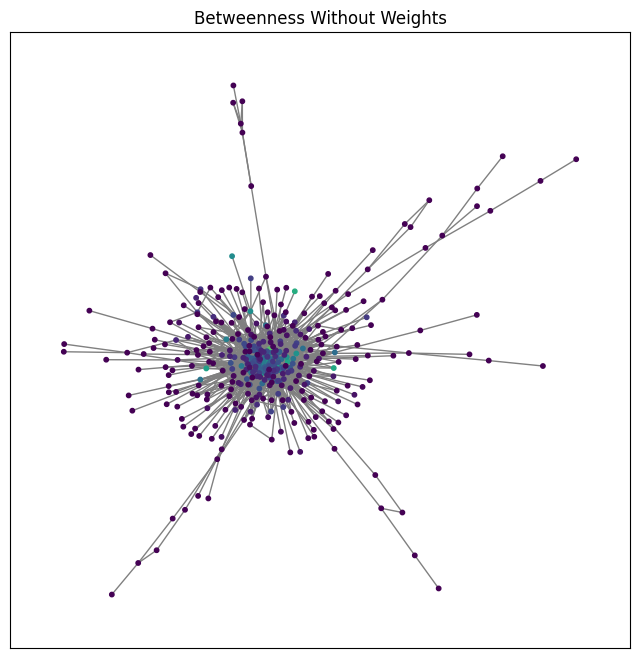

In [30]:
plt.figure(figsize=(8,8))
plt.title("Betweenness Without Weights")
nx.draw_networkx(G0, node_color=[x[1] for x in bet], node_size = 10, with_labels=False, edge_color="grey") 

### 1.3.6 [Discussion](#0) <a id="136"></a>

As we can see, a huge part of those we see are among the top players. We see a combination of good players like Alex and coomo Taylor who have their presence due to their large number of matches; and then others like Daniel and Cem who have their presence due to alternating between the ATP circuit and the lower level Challenger circuit, whereby they make connections with players of both calibres and thus bridge many of the shorter paths, especially those between lesser known players and good players, between players who act as foils for their lower grade and higher grade players.

Taking all things into consideration we can say that globally, the most relevant nodes with respect to centrality are generally those that have played the most matches. We see that Taylor and Alex de Miñaur appear in all of the Top-10 highest values for each centrality measure. Playing more matches will allow you to be a more "central" node in any case, as playing more matches also goes hand in hand with winning more matches and playing with better players who in turn are also central nodes.

## 1.4 [Comparison with a random network and small-world phenomena](#0) <a id="1.4"></a>

### 1.4.1 [Degree Distribution](#0) <a id="141"></a>

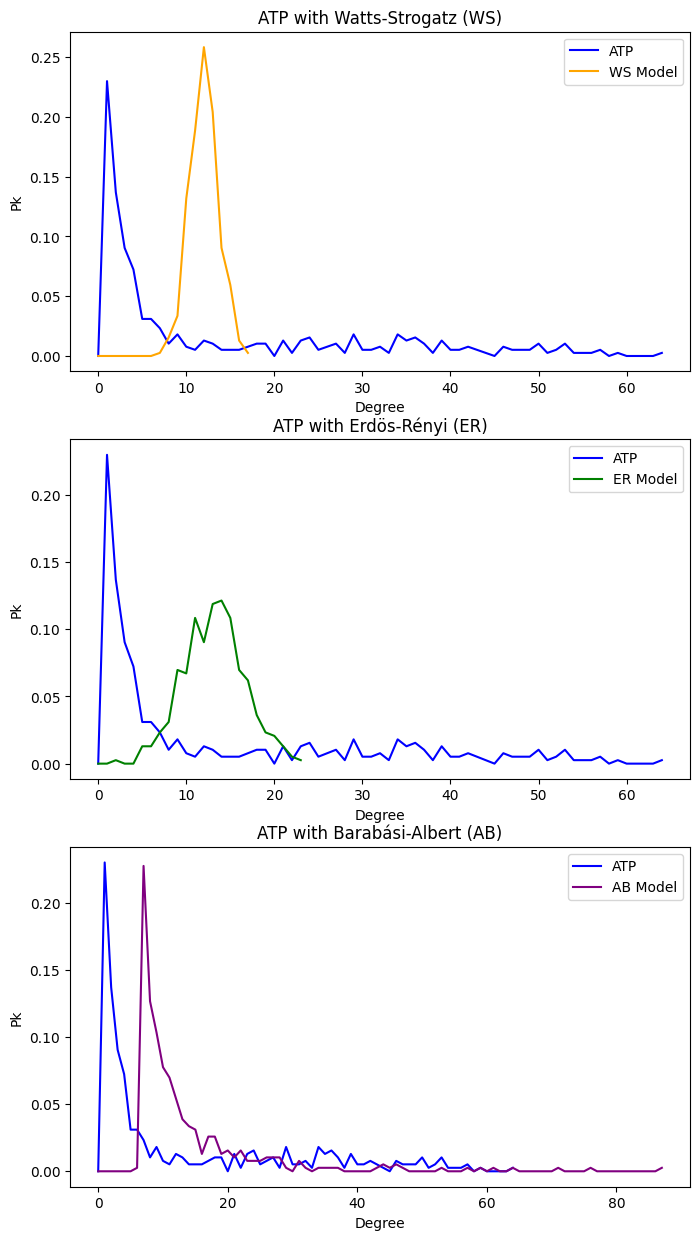

In [30]:
plt.figure(figsize=(8,15))

plt.subplot(3,1,1)
plt.title("ATP with Watts-Strogatz (WS)")

mean_r = np.mean(list(dict(G0.degree).values()))
real_freq = nx.degree_histogram(G0)
real_freq = real_freq/np.sum(real_freq)
real = range(len(real_freq))
plt.plot(real, real_freq, label="ATP", color="blue") 

n = len(G0.nodes)
k = int(mean)
p = 0.3
G = nx.watts_strogatz_graph(n,k=k, p=p)
mean_ws = np.mean(list(dict(G.degree).values()))
degree_freq = nx.degree_histogram(G)
degree_freq = degree_freq/np.sum(degree_freq)
degrees = range(len(degree_freq))
plt.plot(degrees, degree_freq, label="WS Model", color="orange") 
pws = nx.average_shortest_path_length(G)
cws = nx.average_clustering(G)
dws = nx.diameter(G)
ws = round(math.log(len(G.nodes))/math.log(mean_ws),4)

plt.legend(loc="best")
plt.xlabel('Degree')
plt.ylabel('Pk')

plt.subplot(3,1,2)
plt.title("ATP with Erdös-Rényi (ER)")

n = len(G0.nodes)
m = len(G0.edges)
G = nx.generators.gnm_random_graph(n, m)
mean_er = np.mean(list(dict(G.degree).values()))
degree_freq = nx.degree_histogram(G)
degree_freq = degree_freq/np.sum(degree_freq)
degrees = range(len(degree_freq))
plt.plot(real, real_freq, label="ATP", color="blue") 
plt.plot(degrees, degree_freq, label="ER Model", color="green") 
per = nx.average_shortest_path_length(G)
cer = nx.average_clustering(G)
der = nx.diameter(G)
er = round(math.log(len(G.nodes))/math.log(mean_er),4)

plt.legend(loc="best")
plt.xlabel('Degree')
plt.ylabel('Pk')

plt.subplot(3,1,3)
plt.title("ATP with Barabási-Albert (AB)")

n = len(G0.nodes)
m = 7
G = nx.barabasi_albert_graph(n = n, m = 7, initial_graph = None)
#G = nx.barabasi_albert_graph(n=n, m=m)
mean_ab = np.mean(list(dict(G.degree).values()))
degree_freq = nx.degree_histogram(G)
degree_freq = degree_freq/np.sum(degree_freq)
degrees = range(len(degree_freq))
plt.plot(real, real_freq, label="ATP", color="blue") 
plt.plot(degrees, degree_freq, label="AB Model", color="purple") 
pab = nx.average_shortest_path_length(G)
cab = nx.average_clustering(G)
dab = nx.diameter(G)
ab = round(math.log(len(G.nodes))/math.log(mean_ab),4)

plt.xlabel('Degree')
plt.ylabel('Pk')
plt.legend(loc="best")
plt.show()

As we can see with respect to the degree distribution, it does not present a random network behaviour, this is due to the large number of leaves. But the most similar one is the Barabási-Albert (BA) model wich is a preferential attachment networks. So, it follows more or less a Power law. We can assess this with the following graphic:

Calculating best minimal value for power law fit


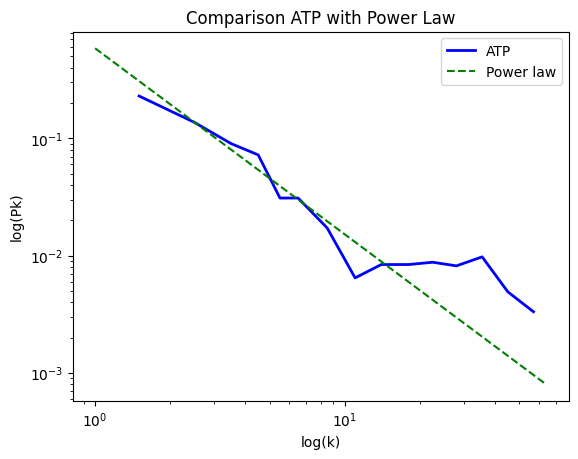

In [141]:
degree_sequence = sorted([d for n, d in G0.degree()], reverse=True)

plt.figure()
fit = powerlaw.Fit(degree_sequence)
fig2 = fit.plot_pdf(color='b', linewidth=2, label="ATP")
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2, label="Power law")
plt.legend(loc="best")
plt.title("Comparison ATP with Power Law")
plt.xlabel("log(k)")
plt.ylabel("log(Pk)")
plt.show()

As we see, is more or less a Scale Free Network, given that it fits more or less well to the straight line.

### 1.4.2 [Clustering Coeffcient](#0) <a id="142"></a>

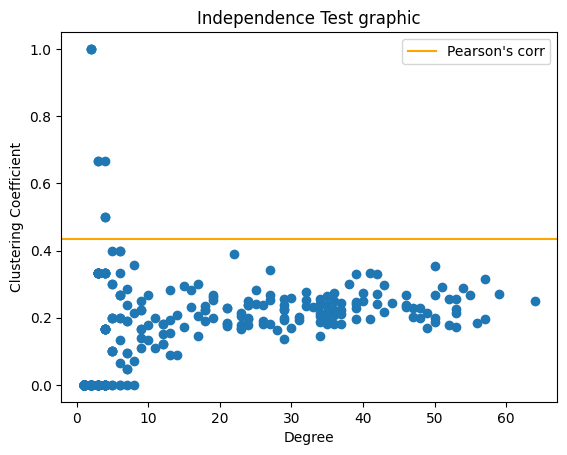

In [159]:
ax = nx.clustering(G0)
ds = dict(G0.degree)
ax = [[x,y] for x,y in dict(ax).items()]

for i,(k,v) in enumerate(ax):
    try:
        deg = ds[k]
    except:
        deg = 0
    ax[i].append(deg)

degs = [x[2] for x in ax]
cts = [x[1] for x in ax]

# calculate Pearson's correlation
corr, _ = pearsonr(degs, cts)
"{:.2f}".format(corr)

plt.title("Independence Test graphic")
plt.scatter(degs, cts)
plt.axhline(corr, label="Pearson's corr", color="orange")
plt.xlabel("Degree")
plt.ylabel("Clustering Coefficient")
plt.legend(loc="best")
plt.show()

In this case we look at the distribution of the clustering coefficients according to the node degree. We see that there is a clear dependency relationship between the two, which is a statement that rejects the hypothesis that this network is random. We can therefore see with these two methods that our network is not a random network.

### 1.4.3 [Small-World phenomena](#0) <a id="143"></a>

In [160]:
path = nx.average_shortest_path_length(G0)
coef = nx.average_clustering(G0)
den = nx.diameter(G0)
real = round(math.log(len(G0.nodes))/math.log(mean),4)

df = pd.DataFrame()
df["network"] = ["Real", "WS", "ER", "AB"]
df["path lenght"] = [round(path,4), round(pws,4), round(per,4), round(pab,4)]
df["cluster"] = [round(coef,4), round(cws,4), round(cer,4), round(cab,4)]
df["d"] = [real, ws, er, ab]
df["dmax"] =  [round(den,4), round(dws,4), round(der,4), round(dab,4)]
df

,network,path lenght,cluster,d,dmax
0,Real,3.1955,0.1341,2.3139,11
1,WS,3.1261,0.1235,4.7080,7
2,ER,2.5947,0.0340,2.3139,4
3,AB,2.4847,0.0955,2.2735,4


As we see, there is a little small world effect on our network as in real networks, being the path lenght more or less equal to d. 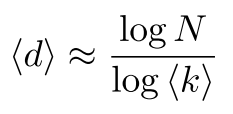


# [Part 2](#0) <a id="part2"></a>

## [2.1 Community analysis](#0) <a id="2.1"></a>

### 2.1.1 [Eigenvalues](#0) <a id="211"></a>

**Apply the method**

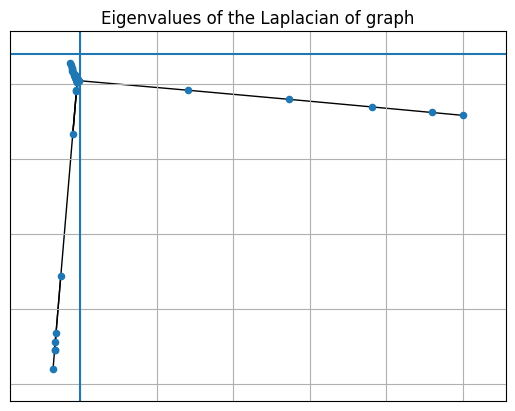

In [249]:
e = nx.laplacian_spectrum(G0)

nx.draw_networkx(G0, pos=nx.spectral_layout(G0), with_labels=False, node_size=20)
plt.title("Eigenvalues of the Laplacian of graph")
plt.axvline(e[0])
plt.axhline(e[1])
plt.grid()
plt.show()

pos=nx.spectral_layout(G0)
groups ={"ar-iz":[], "ar-der":[], "bajo-iz":[], "bajo-der":[]}
for i,coords in pos.items():
    if coords[0] > e[0]:
        if coords[1] > e[1]:
            groups["ar-der"].append(i)
        else:
            groups["bajo-der"].append(i)
    else:
        if coords[1] > e[1]:
            groups["ar-iz"].append(i)
        else:
            groups["bajo-iz"].append(i)  

**Now we can see more information by other methods to try to inference the number of communities**

**Adjacency Matrix**

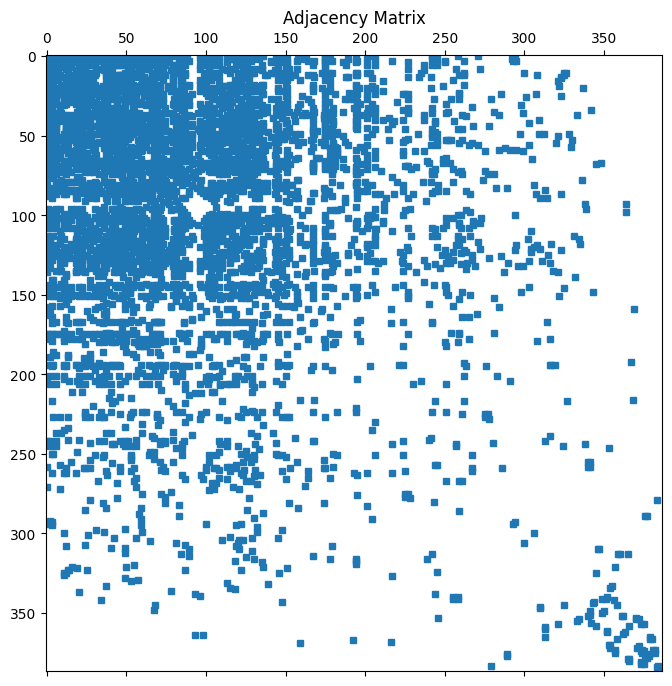

In [250]:
plt.figure(figsize=(8,8))
plt.title("Adjacency Matrix")
plt.spy(nx.adjacency_matrix(G0), markersize=4)
plt.show()

**Adjacency Matrix Heat Map**

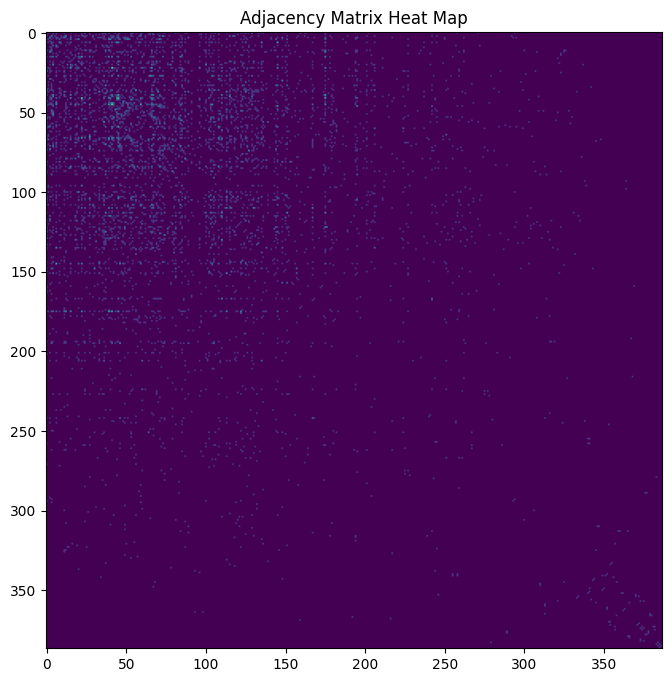

In [179]:
plt.figure(figsize=(8,8))
plt.imshow(nx.adjacency_matrix(G0).toarray())
plt.title("Adjacency Matrix Heat Map")
plt.show()

**Similarity Matrix Heat Map**

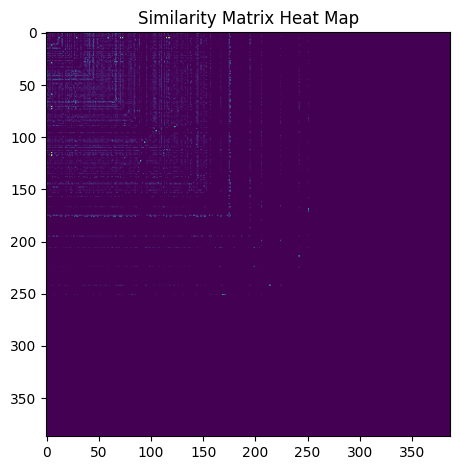

In [185]:
def similarity_matrix(A): #Adjacency Matrix
    H,W = A.shape
    S = np.zeros((H,W))
    for i in range(H):
        for j in range(i,W):
            J = 0
            if i != j:
                for x in range(W):
                    if A[i,x] > 0 and A[j,x] > 1:
                        J+=1
                di = np.sum(A[[i],:])
                dj = np.sum(A[[j],:])
                S[i,j] = J/min(di, dj)
                S[j,i] = J/min(di, dj)
    return S

A = nx.adjacency_matrix(G0)
S = similarity_matrix(A)

fig,ax = plt.subplots(figsize=(8,8))
plt.imshow(S)

labels = list(G0.nodes)
ax.set_title("Similarity Matrix Heat Map")
fig.tight_layout()
plt.show()

### 2.1.2 [Girvan Newman Method](#0) <a id="212"></a>

**Apply the method**

In [228]:
gn = nx_comm.girvan_newman(G0)

C = [x for x in gn]
com = C[0]

**Colour the communities**

In [241]:
#We do Spectrum and Girvan at the same time for efficiency.
colors = []
colors2 = []
for i in list(G0.nodes):
    #For Girvan
    if i in com[0]:
        colors.append("red")
    else:
        colors.append("blue")
    #For Sprectrum
    if i in groups["ar-der"]:
        colors2.append("orange")
    elif i in groups["ar-iz"]:
        colors2.append("green")
    elif i in groups["bajo-der"]:
        colors2.append("red")
    else:
        colors2.append("blue")

### 2.1.3 [Louvain Method](#0) <a id="213"></a>

**Choose the minimum number of communities**

In [281]:
# We do this is to clarify the later view
l = []
for i in range(1000):
    lc = nx_comm.louvain_communities(G0, seed=i)
    n = len(lc)
    l.append(n)
print(l.index(min(l)))

159


**Apply the method**

In [288]:
lc = nx_comm.louvain_communities(G0, seed=l.index(min(l))+100)
part = {}
for p in range(len(lc)):
    for elem in lc[p]:
        part[elem] = p
part_ids = np.zeros(len(G0.nodes))
nodes = list(G0.nodes)
for i,(k,v) in enumerate(part.items()):
    index = nodes.index(k)
    part_ids[index] = v

**Graphic Comparison of the three methods**

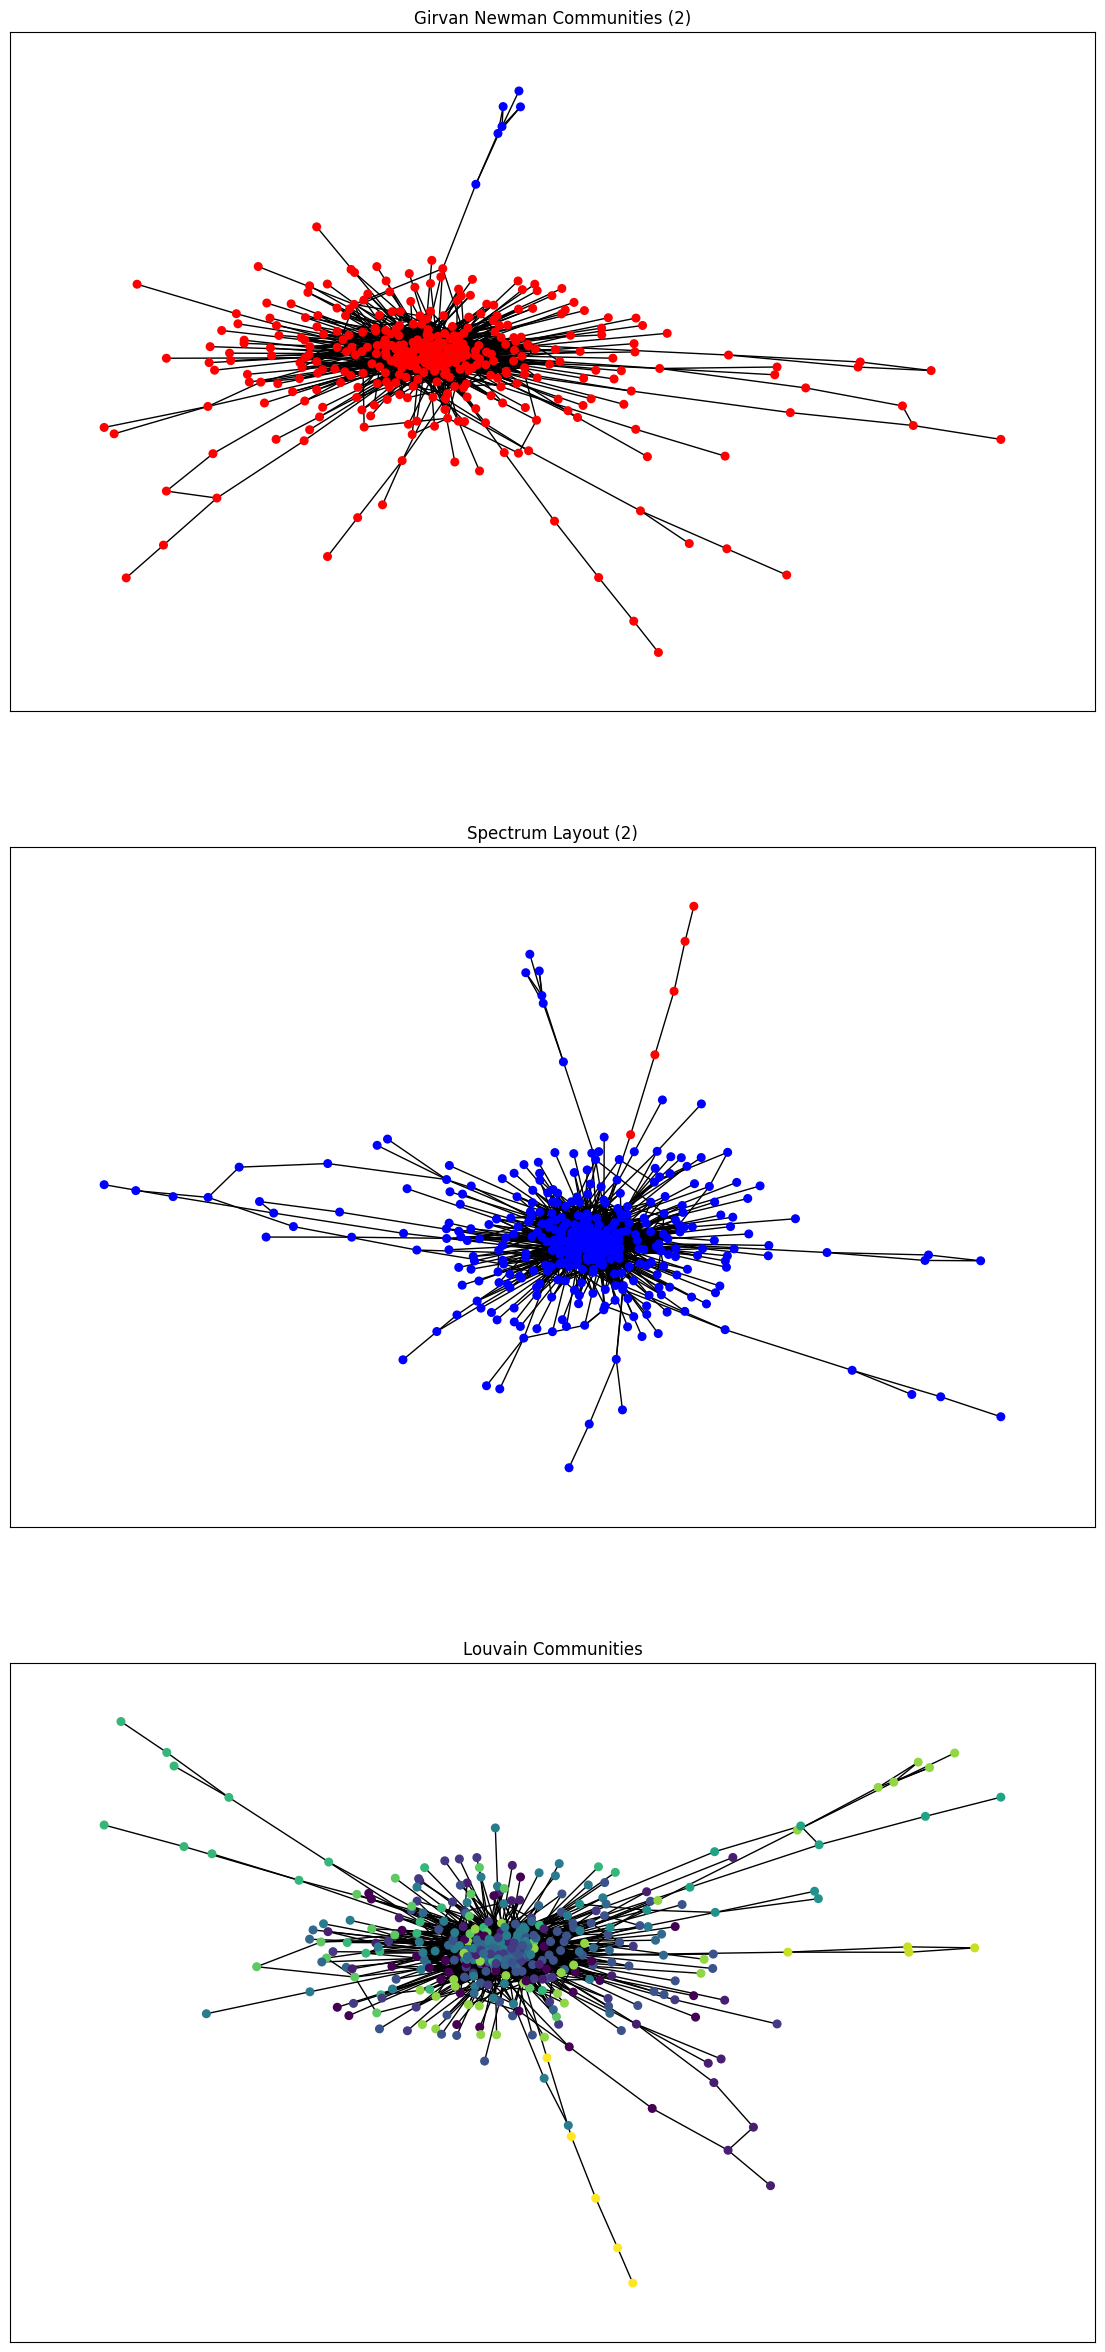

In [289]:
plt.figure(figsize=(14,30))
plt.subplot(3,1,1)
plt.title("Girvan Newman Communities (2)")
nx.draw_networkx(G0, node_color=colors, with_labels=False, node_size=30)
plt.subplot(3,1,2)
plt.title("Spectrum Layout (2)")
nx.draw_networkx(G0, node_color=colors2, with_labels=False, node_size=30)
plt.subplot(3,1,3)
plt.title("Louvain Communities")
nx.draw_networkx(G0, node_color=part_ids, with_labels=False, node_size=30)
plt.show()

### 2.1.4 [Discussion](#0) <a id="214"></a>

After carrying out the community analysis of our network, we proceed to interpret the results.

<br>

- Regarding the first method using **Spectral Layout with the Eigenvalues**, the graph shows two communities, although the second one with only 5 individuals. This becomes credible when looking at the Adjacency matrix, as a large community can be seen in the upper left corner, and a few individuals in the lower corner, so that at first glance we could distinguish two communities.

<br>

- Regarding the **Girvan Newman method**, the algorithm shows something similar to the Spectrum Layout, as again in the second community it shows us 5 individuals despite not being the five previous individuals. In this case and the previous one, we are not talking about 5 known individuals, because if they were, or if they had any relevance within the network, they would not fall into a different community.

<br>

- Regarding the **Louvain Method**, nothing is clear, the low degree nodes are correctly grouped, but in the centre there is a chaos of colours. The algorithm is not finding a way to generate many communities in a clearly ordered way, because there is no way, as there are no communities. For this reason we will not go on to look at the attributes of each community as we cannot consider them as meaningful.

<br>

As previously mentioned there is one Small World Phenomena existing in the network, so the possibility of having more than one community in the network decreases. Are these five individuals really a true community? They are not, but the algorithm has to draw at least two, which explains such divisions. Therefore we claim that in this netwok there is only a single community.

## 2.2 [Extension of the Analysis](#0) <a id="2.2"></a>

### 2.2.1 [Percolation](#0) <a id="221"></a>

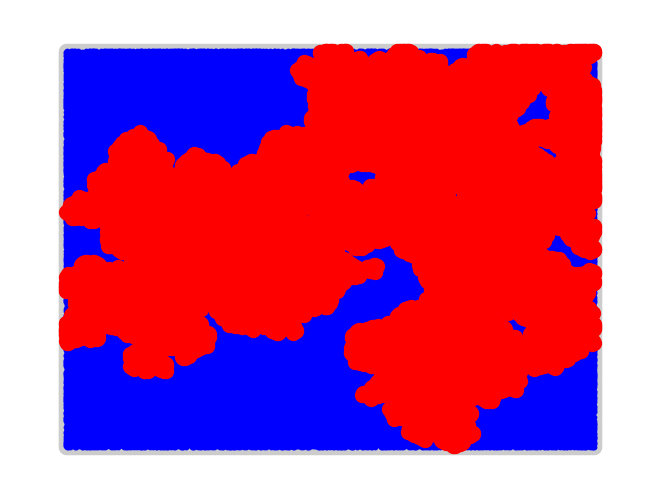

In [31]:
# shows the complete grid as reference
def background(n):
    G = nx.grid_2d_graph(n,n)
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    nx.draw(G, pos = pos,
        node_color=[[0.8, 0.8, 0.8]],
        edge_color=[[0.8, 0.8, 0.8]],
        node_size=100)

# identify largest connected component
def connected(G):
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    nx.draw(G0, pos = pos,
        node_color='r', node_size=100)
    
# generate lattice with probability/density p
def lattice(n, p):
    G = nx.grid_2d_graph(n,n)
    pos = {(x,y):(y,-x) for x,y in G.nodes()}

    # eliminate nodes for a (1-p) probability
    # for example: if you want a p=0.1 of nodes, remnove 0.9
    n_to_remove = int(np.round(n*n * (1 - p)))
    list_of_nodes = np.random.permutation(G.nodes())
    list_of_nodes = list_of_nodes[0:n_to_remove,:]

    # remove_nodes_from() does not work directly with a 2d_grid
    for node in list_of_nodes:
        G.remove_node(tuple(node))

    return G, pos

num_nodes = len(G0.nodes)
p = 0.6
X, pos = lattice(num_nodes, p)
fig = plt.figure()
background(num_nodes)
nx.draw(X, pos = pos,
node_color='b', node_size=10)
connected(X)

C:\Users\samue\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\samue\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


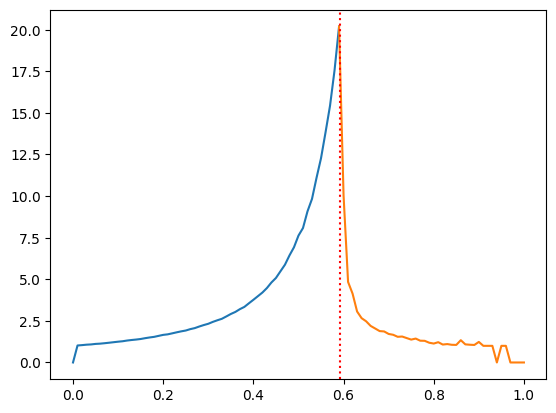

In [17]:
s = []
pinf = []
prob = np.linspace(0,1,101)
pc = 0.593  # the lattice percolation threshold p_c
num_nodes = len(G0.nodes)

# (to complete) repeat several times for the same prob and calculate the average value
for p in prob:
    Gp, pos = lattice(num_nodes, p)
    # obtain the clusters' size
    comp_sizes = [len(c) for c in sorted(nx.connected_components(Gp), key=len, reverse=True)]
    # remove largest one in the second half
    start_at = 0 if p < pc else 1
    # add the mean cluster size
    s.append(np.mean(comp_sizes[start_at:]))
    # add the prob to belong to the largest cluster
    pinf.append(0 if len(comp_sizes) == 0 else comp_sizes[0] / Gp.number_of_nodes())
    
# replace nan by zero
s = [0 if np.isnan(i) else i for i in s]
plt.plot(prob[:60],s[:60]) # it should be 58, but this way looks better...
plt.plot(prob[59:],s[59:])
plt.axvline(x=pc, color='red', linestyle='dotted')
plt.show()

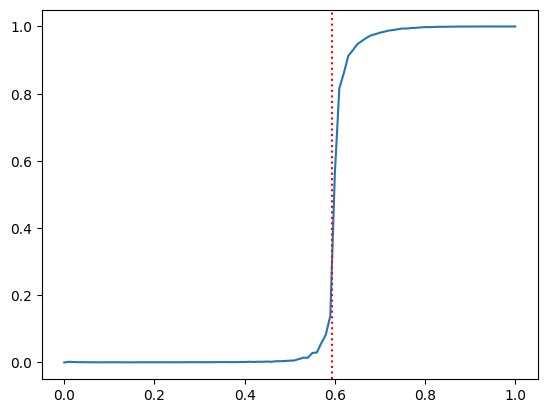

In [25]:
plt.plot(prob,pinf)
plt.axvline(x=pc, color='red', linestyle='dotted')
plt.show()

### 2.2.2 [Robustness](#0) <a id="222"></a>

In [59]:
eff = []
Gx = G0.copy()
# random order for deletion
remove = np.random.permutation(Gx.nodes())
for i in range(num_nodes):
    # calculate the global efficiency of the remaining graph
    eff.append(nx.global_efficiency(Gx))
    # remove the next random node
    Gx.remove_node(remove[i])

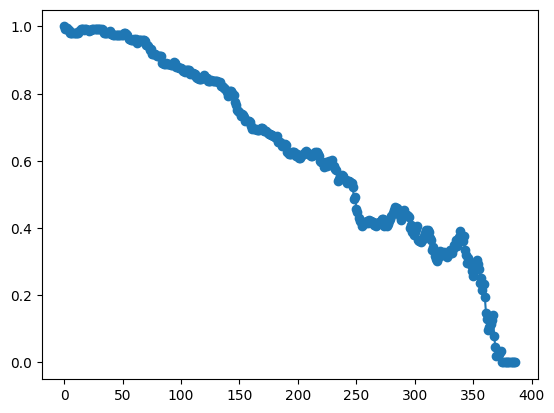

In [60]:
plt.plot(np.array(eff) / eff[0], 'o-')
plt.show()

In [62]:
nnodes = G.number_of_nodes()

# random
Grand = nx.erdos_renyi_graph(nnodes, np.log(nnodes)/nnodes)
Reff = []
Geff = Grand.copy()
remove = np.random.permutation(Geff.nodes())
for i in range(nnodes):
    Reff.append(nx.global_efficiency(Geff))
    # remove the next random node
    Geff.remove_node(remove[i])

# scale
Grand = nx.barabasi_albert_graph(nnodes,7)
SFeff = []
Geff = Grand.copy()
remove = np.random.permutation(Geff.nodes())
for i in range(nnodes):
    SFeff.append(nx.global_efficiency(Geff))
    # remove the next random node
    Geff.remove_node(remove[i])

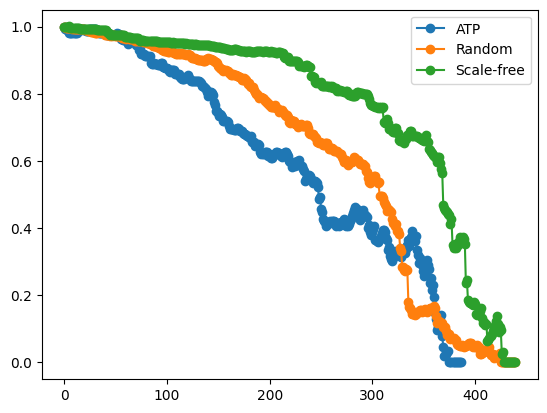

In [63]:
plt.plot(np.array(eff) / eff[0], 'o-', label='ATP')
plt.plot(np.array(Reff) / Reff[0], 'o-', label='Random')
plt.plot(np.array(SFeff) / SFeff[0], 'o-', label='Scale-free')
plt.legend()
plt.show()

### 2.2.3 [Deliberate Attack](#0) <a id="223"></a>

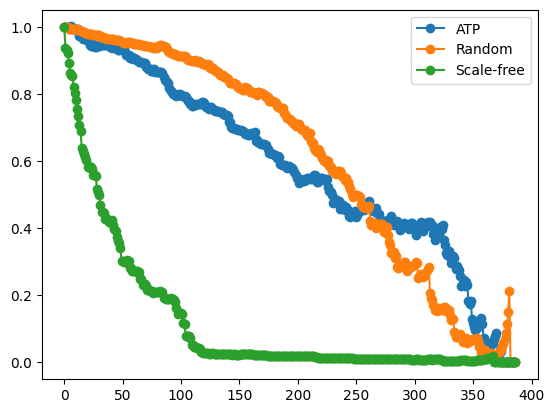

In [66]:
#ATP
eff = []
Gx = G0.copy()
# random order for deletion
remove = np.random.permutation(Gx.nodes())
for i in range(num_nodes):
    remove = [node for (node, val) in sorted(Gx.degree(), key=lambda pair: pair[0])]
    # calculate the global efficiency of the remaining graph
    eff.append(nx.global_efficiency(Gx))
    # remove the next random node
    Gx.remove_node(remove[0])

# random
nnodes = len(G0.nodes)
Grand = nx.erdos_renyi_graph(nnodes, np.log(nnodes)/nnodes)
Reff = []
Geff = Grand.copy()
remove = np.random.permutation(Geff.nodes())
for i in range(nnodes):
    remove = [node for (node, val) in sorted(Geff.degree(), key=lambda pair: pair[0])]
    Reff.append(nx.global_efficiency(Geff))
    # remove the next random node
    Geff.remove_node(remove[0])

# scale
Grand = nx.barabasi_albert_graph(nnodes,2)
SFeff = []
Geff = Grand.copy()
for i in range(nnodes):
    remove = [node for (node, val) in sorted(Geff.degree(), key=lambda pair: pair[0])]
    SFeff.append(nx.global_efficiency(Geff))
    # remove the next random node
    Geff.remove_node(remove.pop(0))
    
plt.plot(np.array(eff) / eff[0], 'o-', label='ATP')
plt.plot(np.array(Reff) / Reff[0], 'o-', label='Random')
plt.plot(np.array(SFeff) / SFeff[0], 'o-', label='Scale-free')
plt.legend()
plt.show()

### 2.2.4 [Cascades](#0) <a id="224"></a>

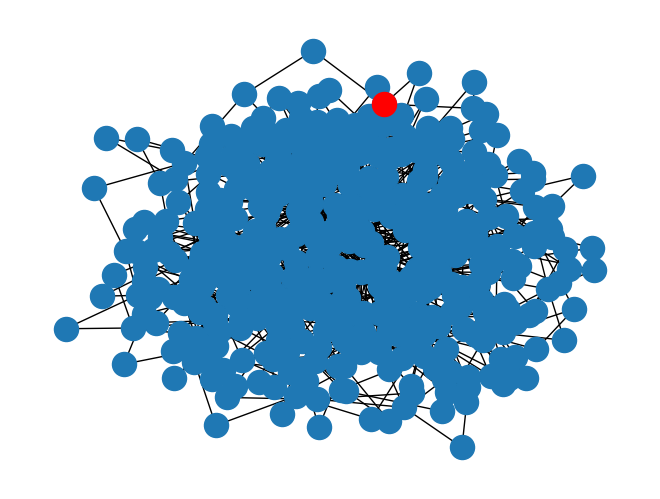

In [27]:
n = len(G.nodes)
Gx = nx.barabasi_albert_graph(n,2)
pos = nx.spring_layout(Gx)
nx.draw(Gx,pos=pos)

# one damaged node
damaged = [np.random.randint(n)]
nx.draw_networkx_nodes(Gx.subgraph(damaged),pos=pos,node_color='red')
plt.show()

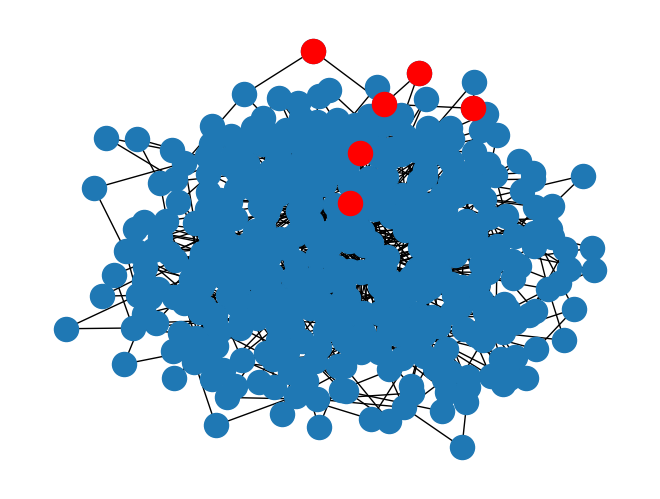

In [28]:
frontier = nx.all_neighbors(Gx, damaged[0])
for node in frontier:
    damaged.append(node)
nx.draw(Gx,pos=pos)
nx.draw_networkx_nodes(Gx.subgraph(damaged),pos=pos,node_color='red')

## [2.3 Conclusions](#0) <a id="2.3"></a>

Once the analyses have been carried out, it is time to summarise the findings and mention proposals for the future.

<br>

The ATP match network turns out to be fairly homogeneous. The vast majority of players, and these are the best players, are in the larger connected component. The large number of leaves, i.e. players who have only been eligible for one ATP match because of their low ranking, makes the Average Shortest Path Length quite low. This gives rise to several hubs within the network, which are the best players who are in the central core of the network. This has also been explained by the network, as there is a clear negative correlation between the number of matches and the ranking, because the higher the ranking, the more chances to play more matches.

<br>

Therefore, the best players are also the ones with the highest values in the centrality measures. Although some nodes are not much more important than the rest, we always find the same ones among the highest, most of which are in the top 25.

<br>

This is a network with Small-world Phenomena. The Average Shortest Path Lenght was already an indicator of this and has been confirmed by calculating the corresponding values. It also shows a significant Power Law network behaviour, being more or less a Scale Free Network.

<br>

Regarding the analysis of communities, it has been concluded that there were none, only one community encompassed all the nodes. This makes sense because having two communities could have meant two different circuits of players, which would not be acceptable, as the circuit is unique, and the match pairings are made randomly, following guidelines by ranking. Perhaps we could have expected to find communities according to ranking, be it top 10, top 10-50, top 50-100, but the truth is that there are more matches between widely separated rankings than matches with even rankings.

<br>

Finally, the extensive analysis, we have seen the robustness of the network, which does not differ much from a Random or a Scale Free network, but with the difference that the ATP network has an almost constant behaviour in the reduction of the global efficiency, and it is normal as there is a large number of cores in the centre that do not generate a significant loss in each iteration. This has been observed together with the deliberate attacks, observing a similar behaviour to the previous one, resembling a random network, so we can say that it is a quite robust network. Certainly we find injured players during the year, players who for various reasons cannot play, and the network is not affected, since in reality, removing a node means adding another one, as the number of matches played each year does not vary.

## 2.4 [Future Proposals](#0) <a id="2.4"></a>

Our work has consisted of an undirected network using as links if there is a match between two players and the players as nodes. Given the large amount of data available it could have been approached in several different ways:

<br>

Consider the network as directed by pointing each arrow if one player who has beaten another.  Organise the players by countries, each country being a node, and each link if there has been a match between two players from one country, the weight being the number of matches played between two countries, with self-loops in the case of two players from the same country playing against each other. The weight could also be taken as the number of ATP points of that match between two players, the age difference of the two players, etc.

<br>

Regarding visualisations, small networks could have been treated within the same, to analyse the most important tournaments of the year, colour the edges by surface played, in the same way analyse separately the networks that form the matches of each surface, categorise the players and colour the network according to ranking groups.

<br>

It would also be interesting to apply this same code to other years and see what differences exist and how tennis is evolving over the years. Another proposal would be to combine this network with that of the other tennis circuits, i.e. Challenger, Future, ITF, etc. and carry out a community analysis to try to see the different circuits as communities.

## 2.5 [References](#0) <a id="2.5"></a>

- Dataset: JeffSackmann. (s. f.). tennis_atp/atp_matches_2023.csv at master · JeffSackmann/tennis_atp. GitHub. https://github.com/JeffSackmann/tennis_atp/blob/master/atp_matches_2023.csv

<br>

- Liu, Chen & Du, Wenbo & Wang, Wen-Xu. (2014). Particle Swarm Optimization with Scale-Free Interactions. PloS one. 9. e97822. 10.1371/journal.pone.0097822. 
